In [22]:
#Importing Libraries
#Data Handling
import pandas as pd
import numpy as np

import sys
sys.path.append('../..')

from source import *
import source.fairness as fm
import source.pipes as op
import source.utils as ut
from source.estimators import FORESEE

#Storing trains
import pickle

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# #Run following codes for loading pipelines on dictionary from pickles
path_dir = '../../pipes/adult-income/fairness/'
preprocessing_pickles = op.import_pickle(path_dir + 'preprocessing.pickle')
preprocessing_pickles_norm = op.import_pickle(path_dir + 'preprocessing_norm.pickle')
y = op.import_pickle(path_dir + 'y.pickle') 
data_test_prepro = op.import_pickle(path_dir + 'preprocessing_test.pickle')
data_test_prepro_norm = op.import_pickle(path_dir + 'preprocessing_test_norm.pickle')
A = op.import_pickle(path_dir + 'A.pickle')
aware_features = op.import_pickle(path_dir + 'preprocessing_features_aware.pickle')
gender_features = op.import_pickle(path_dir + 'preprocessing_features_sex.pickle')
    

In [4]:
#Run this for creating dictionary of datasets, nompipelines, and numpipelines
datasets_prepro = {}
datasets_prepro_norm = {}
pipes_nominal = {}
pipes_numerical = {}

for p in preprocessing_pickles_norm:
    d , pnom, pnum = preprocessing_pickles_norm[p]
    datasets_prepro_norm[p] = d

for p in preprocessing_pickles:
    d , pnom, pnum = preprocessing_pickles[p]
    datasets_prepro[p] = d
    pipes_nominal[p] = pnom
    pipes_numerical[p] = pnum
    
for yval in y:
    y_train = y['train']
    y_test = y['test']
    
for Aval in A:
    A_train = A['train']
    A_test = A['test']
    
#Get in a dictionary all preprocessed datasets.
datasets_train = {}
for d in datasets_prepro:
    ds = datasets_prepro[d]
    datasets_train[d] = ds
    
datasets_norm_train = {}
for d in datasets_prepro_norm:
    ds = datasets_prepro_norm[d]
    datasets_norm_train[d] = ds
    
#Get in a dictionary all preprocessed datasets.
datasets_test = {}
for d in data_test_prepro:
    ds = data_test_prepro[d]
    datasets_test[d] = ds
datasets_test.keys()

datasets_norm_test = {}
for d in data_test_prepro_norm:
    ds = data_test_prepro_norm[d]
    datasets_norm_test[d] = ds
datasets_norm_test.keys()


dict_keys(['aware', 'sex'])

In [9]:
X_t = datasets_train['sex'].toarray()
A_t = np.array(A_train['sex'])
y_t = y_train.to_numpy().reshape(-1)

X_tt  = datasets_test['sex'].toarray()
A_tt = np.array(A_test['sex'])
y_tt = y_test.to_numpy().reshape(-1)

In [4]:
X_prueba = np.concatenate((X_t, 1*(A_t==' Female').reshape(-1,1)), axis=1)

In [39]:
fsee= FORESEE(min_samples_leaf=[2])
fsee.fit(X=X_prueba,
         A=A_t,
         priv_class=' Male',
         y=y_t,
         scoring = ['accuracy'])

Complete                    

In [79]:
with open('checkpoints/fsee.pickle', 'wb') as f:
    pickle.dump(fsee, f, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
fsee = op.import_pickle('checkpoints/fsee.pickle')

In [8]:
risks_train, disc_acc_train, count_disc_train = fsee.risk_disc(X=X_prueba,
                                                               y=y_t,
                                                               A=A_t,
                                                               priv_class=' Male', 
                                                               beta=0.61)


In [6]:
X_prueba_test = np.concatenate((X_tt, 1*(A_tt==' Female').reshape(-1,1)), axis=1)

In [10]:
risks_test, disc_acc_test, count_disc_test = fsee.risk_disc(X=X_prueba_test,
                                                            y=y_tt,
                                                            A=A_tt,
                                                            priv_class=' Male', 
                                                            beta=0.61)


In [11]:
#checkpoints
with open('checkpoints/risks_train.pickle', 'wb') as f:
    pickle.dump(risks_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('checkpoints/risks_test.pickle', 'wb') as f:
    pickle.dump(risks_test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
risks_train = op.import_pickle('checkpoints/risks_train.pickle')
risks_test = op.import_pickle('checkpoints/risks_test.pickle')


# Analayzing Results

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


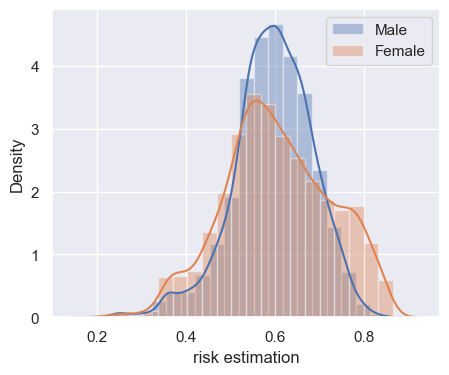

In [10]:
plt.figure(figsize=(5, 4))
sns.distplot(risks_test['th_beta'][A_tt==' Male'], hist=True, kde=True, bins=20, label='Male')
sns.distplot(risks_test['th_beta'][A_tt==' Female'], hist=True, kde=True, bins=20, label='Female')
plt.xlabel('risk estimation')
plt.legend()
plt.show()

# Models

In [11]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [12]:
#Obtain the X, Y and risk
X_train_models = datasets_norm_train['aware'].toarray()
X_test_models = datasets_norm_test['aware'].toarray()

In [16]:
parameters = {'LR__C':[0.01, 0.1, 1], 'LR__fit_intercept':[True, False], 'LR__solver': ['liblinear','lbfgs'], 'LR__class_weight': [None,'balanced'], 'LR__max_iter' : [100000]}
lr = LogisticRegression(random_state=0)

fit_lr = op.get_grid(X_train_models, y_t, parameters, lr, 'LR', scoring=['f1'], refit='f1')


In [17]:
parameters = {'RF__class_weight': ['balanced'],'RF__n_estimators':[10, 50, 100], 'RF__criterion': ['gini', 'entropy'], 'RF__max_depth': [None, 5, 10, 15]}
rf = RandomForestClassifier(random_state=0)

fit_rf = op.get_grid(X_train_models, y_t, parameters, rf, 'RF', scoring=['f1'], refit='f1')


In [18]:
parameters = {'KNN__weights': ['uniform', 'distance'],'KNN__n_neighbors': [5, 10, 15, 20, 25, 30]}
knn = KNeighborsClassifier()

fit_knn = op.get_grid(X_train_models, y_t, parameters, knn, 'KNN', scoring=['f1'], refit='f1')
        

In [19]:
parameters = {'SVM__probability':[True],'SVM__kernel':['rbf', 'sigmoid'], 'SVM__C': [0.001, 0.01, 1, 10, 100], 'SVM__class_weight': [None,'balanced']}
svm = SVC(random_state=0)

fit_svm = op.get_grid(X_train_models, y_t, parameters, svm, 'SVM', scoring=['f1'], refit='f1')


In [17]:
parameters = {'MLP__hidden_layer_sizes':
                                [(10, 10), (10, 100), (10, 500),
                                (100, 10), (100, 100), (100, 500),
                                (500, 10), (500, 100), (500, 500)],
            'MLP__learning_rate_init': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
            'MLP__max_iter': [1000],
            'MLP__tol': [1e-4]},
mlp = MLPClassifier(random_state=0)

fit_mlp = op.get_grid(X_train_models, y_t, parameters, mlp, 'MLP', scoring=['f1'], refit='f1')

In [19]:
models = {'LR': fit_lr,
        'RF': fit_rf,
        'KNN': fit_knn,
        'SVM': fit_svm,
        'MLP': fit_mlp}


In [23]:
models_results = pd.DataFrame(columns=['model','performance','eq_opp','eq_odd','dem_p'])

for m in models:
    clf = models[m].best_estimator_[m]
    y_pred = clf.predict(X_test_models)

    perfo = fm.f1score(y_tt, y_pred)
    eq_opp = fm.equal_opp_dif(y_tt, y_pred, A_tt, ' Male')
    eq_odd = fm.equalized_odd_dif(y_tt, y_pred, A_tt, ' Male')
    dem_p = fm.demographic_parity_dif(y_pred, A_tt,' Male')

    new_r = {'model': m,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results = models_results.append(new_r, ignore_index=True)
models_results

,model,performance,eq_opp,eq_odd,dem_p
0,LR,0.618472,-0.409657,0.321224,-0.351572
1,RF,0.703699,-0.200369,0.208051,-0.331891
2,KNN,0.644371,-0.208270,0.148633,-0.199905
3,SVM,0.666094,-0.212210,0.247398,-0.382730
4,MLP,0.657565,-0.121548,0.096847,-0.176467


In [18]:
models = op.import_pickle('checkpoints/models.pickle')

fit_lr = models['LR']
fit_rf = models['RF']
fit_knn = models['KNN']
fit_svm = models['SVM']
fit_mlp = models['MLP']


In [26]:
models_results = pd.DataFrame(columns=['model','performance','eq_opp','eq_odd','dem_p'])

for m in models:
    clf = models[m].best_estimator_[m]
    y_pred = clf.predict(X_test_models)

    perfo = fm.f1score(y_tt, y_pred)
    eq_opp = fm.equal_opp_dif(y_tt, y_pred, A_tt, ' Male')
    eq_odd = fm.equalized_odd_dif(y_tt, y_pred, A_tt, ' Male')
    dem_p = fm.demographic_parity_dif(y_pred, A_tt,' Male')

    new_r = {'model': m,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results = models_results.append(new_r, ignore_index=True)
models_results

,model,performance,eq_opp,eq_odd,dem_p
0,LR,0.618472,-0.409657,0.321224,-0.351572
1,RF,0.703699,-0.200369,0.208051,-0.331891
2,KNN,0.644371,-0.208270,0.148633,-0.199905
3,SVM,0.666094,-0.212210,0.247398,-0.382730
4,MLP,0.657565,-0.121548,0.096847,-0.176467


In [25]:
with open('checkpoints/models.pickle', 'wb') as f:
    pickle.dump(models, f, protocol = pickle.HIGHEST_PROTOCOL)

In [24]:
models.keys()

dict_keys(['LR', 'RF', 'KNN', 'SVM', 'MLP'])

# Finding High and Low Risk Groups

In [27]:
threshold = .5

X_train_high = X_train_models[risks_train['th_beta']>=threshold]
y_train_high = y_t[risks_train['th_beta']>=threshold]
A_train_high = A_t[risks_train['th_beta']>=threshold]

X_train_low = X_train_models[risks_train['th_beta']<threshold]
y_train_low = y_t[risks_train['th_beta']<threshold]
A_train_low = A_t[risks_train['th_beta']<threshold]

X_test_high = X_test_models[risks_test['th_beta']>=threshold]
y_test_high = y_tt[risks_test['th_beta']>=threshold]
A_test_high = A_tt[risks_test['th_beta']>=threshold]

X_test_low = X_test_models[risks_test['th_beta']<threshold]
y_test_low = y_tt[risks_test['th_beta']<threshold]
A_test_low = A_tt[risks_test['th_beta']<threshold]


In [28]:
models_results_both = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['high','low']

for m in models.keys():
    for s in scenario:
        if s == 'high':
            X_test_model = X_test_high
            y_test_model = y_test_high
            A_test_model = A_test_high
        else:
            X_test_model = X_test_low
            y_test_model = y_test_low
            A_test_model = A_test_low

        clf =  models[m].best_estimator_[m]
        y_pred = clf.predict(X_test_model)

        perfo = fm.f1score(y_test_model, y_pred)
        eq_opp = fm.equal_opp_dif(y_test_model, y_pred, A_test_model, ' Male')
        eq_odd = fm.equalized_odd_dif(y_test_model, y_pred, A_test_model, ' Male')
        dem_p = fm.demographic_parity_dif(y_pred, A_test_model,' Male')

        new_r = {'model': m,
                 'scenario': s,
                 'performance': perfo,
                 'eq_opp': eq_opp,
                 'eq_odd': eq_odd,
                 'dem_p': dem_p}

        models_results_both = models_results_both.append(new_r, ignore_index=True)
    models_results_both

In [29]:
models_results_both

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,LR,high,0.611756,-0.496583,0.379461,-0.391237
1,LR,low,0.712095,-0.003241,0.031649,-0.068104
2,RF,high,0.696105,-0.246217,0.247214,-0.372449
3,RF,low,0.817490,0.026067,0.028927,-0.040882
4,KNN,high,0.648874,-0.231210,0.167064,-0.225839
5,KNN,low,0.572193,0.050867,0.030358,-0.010834
6,SVM,high,0.659822,-0.245443,0.286187,-0.428557
7,SVM,low,0.766423,-0.009863,0.020313,-0.043435
8,MLP,high,0.649000,-0.178582,0.131019,-0.201845
9,MLP,low,0.768889,0.114344,0.061286,-0.007064


# Profiles

In [19]:
aware_dataset = pd.DataFrame(X_tt, columns=gender_features)
sex_dataset = pd.DataFrame(1*(A_tt==' Male'), columns=['sex']) #if 1, then ' Male'
risk_dataset = pd.DataFrame(risks_test['th_beta'], columns=['risk'])
label_dataset = pd.DataFrame(y_tt, columns = ['label'])
bins = pd.DataFrame(np.zeros((y_tt.shape[0])), columns = ['bins'])
profile_dataset = pd.concat([aware_dataset, sex_dataset, bins, risk_dataset, label_dataset], axis=1)

#Scaled and standardize all variables
for i in range(len(profile_dataset.columns)-4):
    profile_dataset.iloc[:,i]=(profile_dataset.iloc[:,i]-profile_dataset.iloc[:,i].mean())/(profile_dataset.iloc[:,i].std())
     
profile_dataset

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass,marital-status,occupation,relationship,race,native-country,sex,bins,risk,label
0,-0.410357,1.531625,-0.143181,-0.224849,0.374296,-1.502588,0.922284,0.566302,-0.275665,0.389497,0.248849,0,0.0,0.610250,0
1,-0.846210,-0.430888,-0.143181,-0.224849,-0.025500,-1.502588,-1.743638,0.796381,0.969695,0.389497,0.248849,1,0.0,0.622763,0
2,0.243423,-0.430888,-0.143181,-0.224849,-0.025500,-0.260070,-1.743638,-0.814171,-0.275665,0.389497,0.248849,0,0.0,0.694448,0
3,-0.119788,1.531625,-0.143181,-0.224849,2.373277,-0.260070,-0.410677,0.566302,-0.898345,0.389497,0.248849,1,0.0,0.609175,0
4,0.679276,-0.038385,0.804227,-0.224849,1.573685,0.982448,-0.410677,-0.584092,-0.898345,0.389497,0.248849,1,0.0,0.698679,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14648,-1.354705,-0.430888,-0.143181,-0.224849,0.374296,-0.260070,0.922284,0.336223,-0.275665,0.389497,0.248849,0,0.0,0.514319,0
14649,-1.282063,-0.430888,-0.143181,-0.224849,-0.025500,-0.260070,0.922284,1.486618,-0.275665,0.389497,0.248849,1,0.0,0.530365,0
14650,-0.265072,1.139123,-0.143181,-0.224849,0.774092,-0.260070,0.922284,0.566302,-0.275665,0.389497,0.248849,1,0.0,0.551095,1
14651,-0.991494,-0.823390,-0.143181,-0.224849,-0.025500,-0.260070,-0.410677,-0.123935,-0.898345,0.389497,-4.903764,1,0.0,0.648752,0


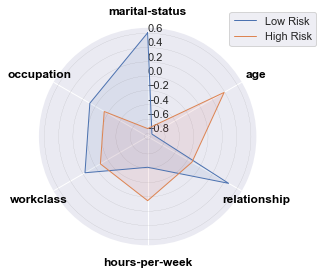

In [21]:
#Plot
numbers_features = 6
features = profile_dataset.columns
bins =5
priv = 1
sens_attr = 'sex'
ascending = True

profile_dataset_result, ds_radarchart_result, categories = ut.plotProfiles(profile_dataset=profile_dataset, 
                                                               numbers_features=numbers_features, 
                                                               features=features, 
                                                               bins=bins, 
                                                               priv=priv, 
                                                               sens_attr=sens_attr, 
                                                               ascending=ascending)


In [22]:
ds_radarchart_result

,marital-status,age,relationship,hours-per-week,workclass,occupation
bins,,,,,,
1.0,0.606223,-0.774138,0.463089,-0.414213,0.167536,0.088941
2.0,0.136570,-0.066267,-0.032248,0.085717,-0.076174,-0.032814
3.0,0.091060,0.174848,-0.077105,0.123335,-0.022935,0.072760
4.0,-0.100760,0.274325,-0.225069,0.153064,0.012699,0.014474
5.0,-0.731096,0.390167,-0.128317,0.051955,-0.080905,-0.142971


In [23]:
pd.pivot_table(profile_dataset_result, values=['sex'], index=['bins'])

,sex
bins,
1.0,0.666439
2.0,0.666439
3.0,0.666439
4.0,0.666439
5.0,0.665986


In [24]:
pd.pivot_table(profile_dataset_result, values=['label'], index=['bins'])

,label
bins,
1.0,0.137931
2.0,0.266302
3.0,0.281325
4.0,0.302834
5.0,0.208035
